# Heart Disease Prediction System
## Final Year Project (2022)

This notebook presents the complete implementation of a heart disease
prediction system using machine learning. The project includes data
visualization, preprocessing, model training, evaluation, and ensemble learning.

**Tools Used:** Python, Pandas, Seaborn, Scikit-learn  
**Dataset:** UCI Heart Disease Dataset



In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

import joblib

sns.set(style="whitegrid")


In [17]:
data = pd.read_csv("heart.csv")
data.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## Dataset Overview

The dataset consists of 14 attributes related to patient health parameters.
The target variable indicates the presence or absence of heart disease.


In [18]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [19]:
data.describe()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


## Exploratory Data Analysis (EDA)

Visualizations are used to understand the data distribution,
relationships between features, and correlation patterns.


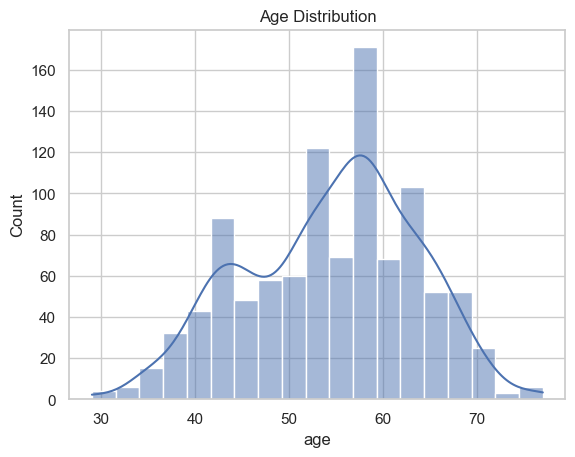

In [20]:
sns.histplot(data["age"], kde=True)
plt.title("Age Distribution")
plt.show()



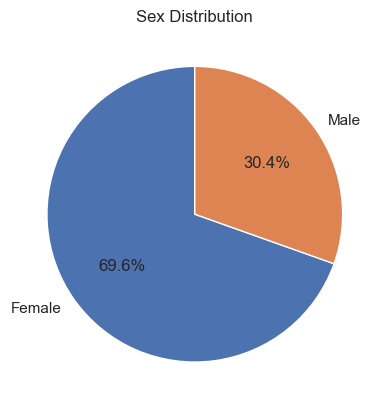

In [21]:
data["sex"].value_counts().plot.pie(
    autopct="%1.1f%%",
    labels=["Female", "Male"],
    startangle=90
)
plt.title("Sex Distribution")
plt.ylabel("")
plt.show()


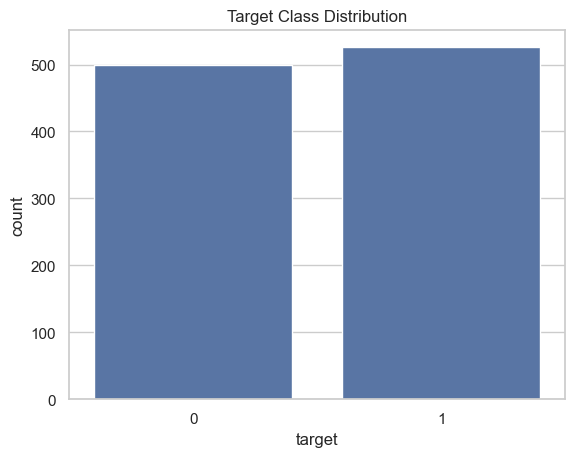

In [22]:
sns.countplot(x=data["target"])
plt.title("Target Class Distribution")
plt.show()


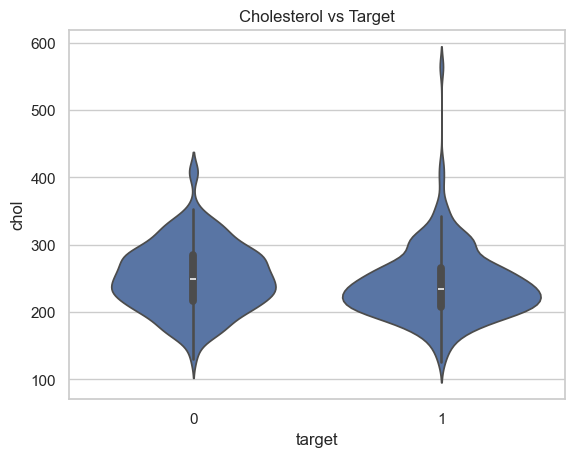

In [23]:
sns.violinplot(x=data["target"], y=data["chol"])
plt.title("Cholesterol vs Target")
plt.show()


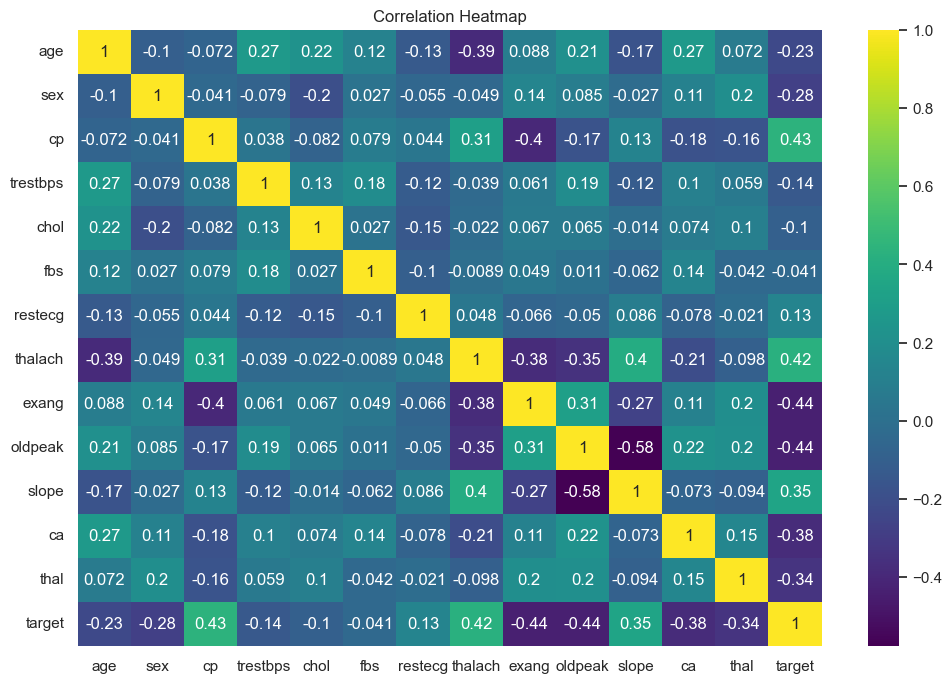

In [24]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap="viridis")
plt.title("Correlation Heatmap")
plt.show()


## Data Cleaning

Outliers are handled using the Interquartile Range (IQR) method
to prevent skewed model training.


In [25]:
def iqr_cap(col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data[col] = np.clip(data[col], lower, upper)

for col in ["trestbps", "chol", "thalach", "oldpeak", "ca", "thal"]:
    iqr_cap(col)


## Data Preprocessing

The dataset is split into features and target.
Feature scaling is applied to normalize the input range.


In [26]:
X = data.drop("target", axis=1)
y = data["target"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42
)


## Model Training

Multiple supervised learning algorithms are trained and evaluated
using ROC-AUC score.


In [27]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=8),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "AdaBoost": AdaBoostClassifier(n_estimators=200),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:, 1]
    scores[name] = roc_auc_score(y_test, probs)

scores


{'Logistic Regression': 0.8956363636363637,
 'Decision Tree': 0.9746060606060606,
 'Random Forest': 1.0,
 'AdaBoost': 0.9624848484848485,
 'KNN': 0.9430000000000001}

## Ensemble Learning

A soft voting classifier is used to combine the strengths
of multiple algorithms.


In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import joblib

ensemble = VotingClassifier(
    estimators=[
        ("RF", RandomForestClassifier(n_estimators=200, random_state=42)),
        ("DT", DecisionTreeClassifier(max_depth=8, random_state=42)),
        ("KNN", KNeighborsClassifier(n_neighbors=5))
    ],
    voting="soft"
)

calibrated_ensemble = CalibratedClassifierCV(
    ensemble,
    method="sigmoid",   
    cv=5
)

calibrated_ensemble.fit(X_train, y_train)

# Evaluate
ensemble_probs = calibrated_ensemble.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, ensemble_probs)
print("Calibrated Ensemble ROC-AUC:", roc_auc)



Calibrated Ensemble ROC-AUC: 1.0


In [29]:
# Save FINAL model
joblib.dump(calibrated_ensemble, "final_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

## Conclusion

The project successfully demonstrates the application of machine learning
techniques for heart disease prediction. Data visualization and preprocessing
improved model understanding and performance. Ensemble learning achieved
better generalization and was integrated into a web application using Flask
and React.
